### Test dynamic sim functionality

In [1]:
import numpy as np
import math
import scipy

from matplotlib import pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=20)

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader

import os
import argparse
import time
from tqdm import tqdm # Loading bar
print('Done.')

Done.


In [2]:
from utils import complex_conj_transpose, batched_complex_conj_transpose, complex_exp, complex_exp_v2, complex_hadamard, complex_matmul, complex_division
from utils import batched_complex_conj_transpose, batched_complex_hadamard, batched_complex_matmul, batched_complex_division
from utils import batched_complex_exp, batched_complex_hadamard_full, batched_complex_matmul_full
print('Done.')

Done.


In [3]:
from model import compute_lambda_h
from model import HadamardLayer, TemporalNorm, TemporalWhiteningLayer
print('Done.')

Done.


In [4]:
from dynamics import stochastic_LTI, DynamicSim
from dynamics import construct_mapping
from dynamics import get_nth_measurement, get_random_measurements
from dynamics import linear_spiral, linear_spiral_3D, Lorenz, rand_coupling_matrix, Van_der_Pol_osc
print('Done.')

Done.


In [5]:
parser = argparse.ArgumentParser('DA')
parser.add_argument('--gpu', type=int, default=0) # (Default: 0)
args = parser.parse_args(args=[])
args.device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
print(args.device)

torch.manual_seed(2025)
np.random.seed(2025)

cuda:0


2D Spiral

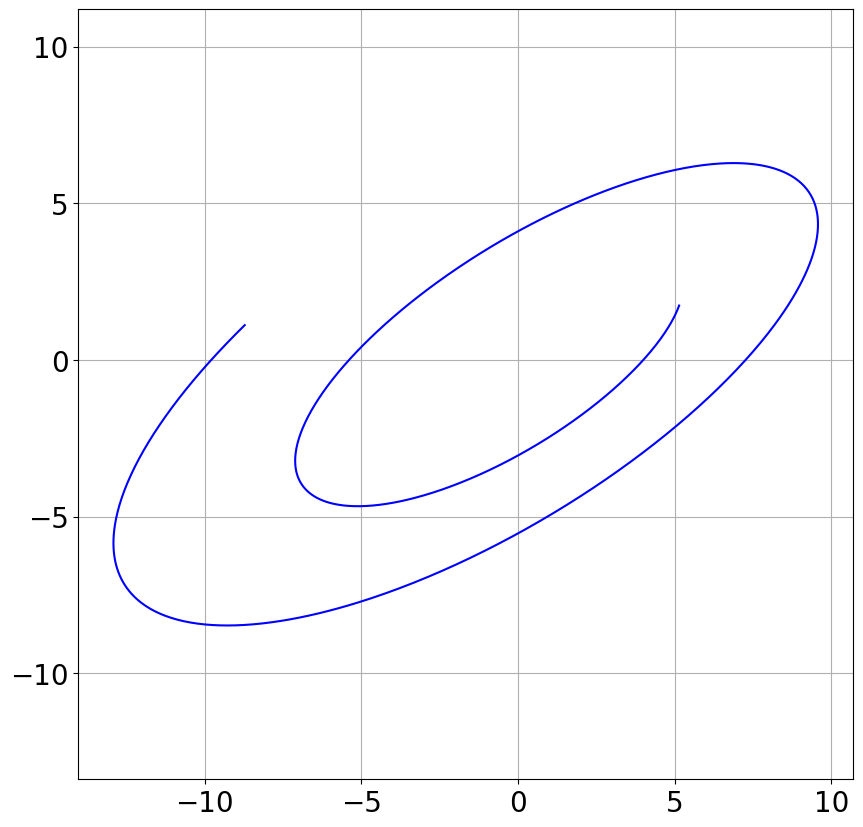

In [6]:
# Set random seed
seed = 1

# Process & measurement noise
sigma_process = 0
sigma_process_0 = 0
sigma_measure = 0

# Defines a stable 2D linear system:
D1 = torch.zeros(2,2,2).to(args.device) # Diagonal matrix
S1 = torch.zeros(2,2,2).to(args.device) # Unitary matrix
Si1 = torch.zeros(2,2,2).to(args.device) # Inverse of unitary matrix
D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.1]]).to(args.device)
D1[1] = torch.tensor([[-1.0, 0.0], [0.0, 1.0]]).to(args.device)
# D1[0] = torch.tensor([[-0.1, 0.0], [0.0, -0.5]]).to(args.device)
# D1[1] = torch.tensor([[-0.0, 0.0], [0.0, 0.0]]).to(args.device)
S1[0] = torch.tensor([[1.0, 1.0], [1.0, 1.0]]).to(args.device)
S1[1] = torch.tensor([[-1.0, 1.0], [0.0, 0.0]]).to(args.device)
Si1[0] = 0.5*torch.tensor([[0.0, 1.0], [0.0, 1.0]]).to(args.device)
Si1[1] = 0.5*torch.tensor([[1.0, -1.0], [-1.0, 1.0]]).to(args.device)
A = complex_matmul(S1,complex_matmul(D1,Si1))
params = [D1, S1, Si1]

# U = torch.zeros(2,2,2).to(args.device)
# U[0] = torch.tensor(([1,1],[0,0]))
# U[1] = torch.tensor(([0,0],[1,-1]))
# U = U/np.sqrt(2)
# Us = complex_conj_transpose(U)
# A = complex_matmul(U,complex_matmul(Lambda,Us))
# params = [Lambda, U, Us]

# Initial conditions
t0 = 0 # Start time
tf = 10 # End time
args.dt = 0.01
args.m = 2
x0 = (torch.randn(args.m)*10).to(args.device) # Initial condition

spiral1 = linear_spiral(params).to(args.device)

# Instantiate the system model and simulator
sim = DynamicSim(args.device)
sim.set_model(spiral1)

# Run the simulation
X, X_measure, Xp = sim.simulate_ODE(x0, tf, t0, args.dt, sigma_process, sigma_process_0, sigma_measure)
# X2, X_measure2, Xp2 = sim.simulate_ODE(x0_2, tf, t0, dt, sigma_process, sigma_process_0, sigma_measure)

# Plot
X_plt = X.cpu().detach().numpy().squeeze().T
# X_plt2 = X2.cpu().detach().numpy().squeeze().T
# X_plt = X_measure.cpu().detach().numpy().squeeze().T
# X_plt2 = X_measure2.cpu().detach().numpy().squeeze().T

fig = plt.figure()
plt.plot(X_plt[0], X_plt[1], 'b')
# plt.plot(X_plt2[0], X_plt2[1], 'r--')

# plt.scatter(xp[0]*range(10), xp[1]*range(10))

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axis('equal')
plt.grid()
plt.show()

3D Spiral

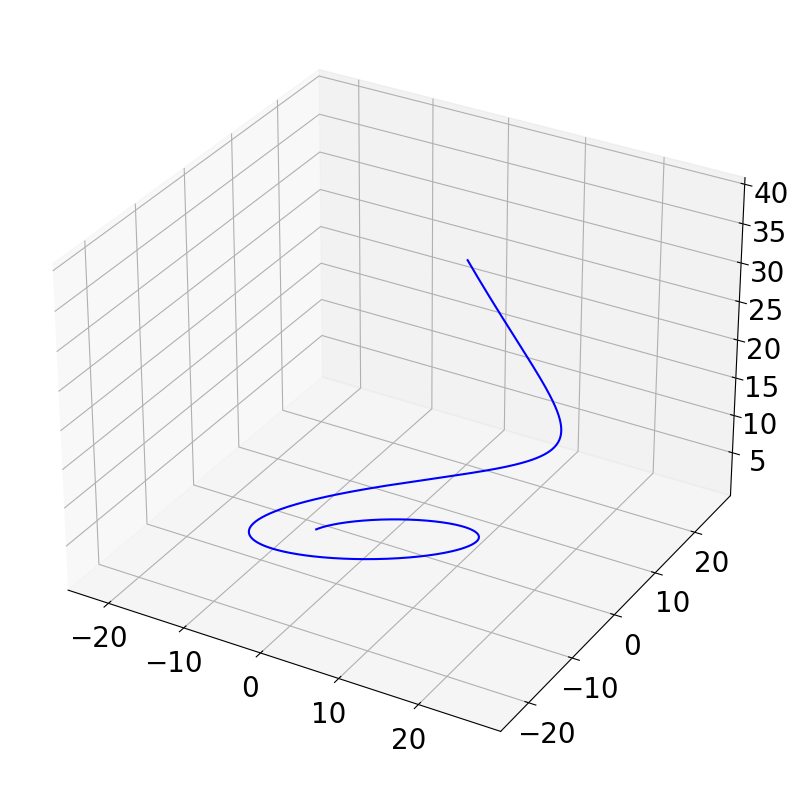

In [7]:
args.m = 3
x0 = (torch.randn(args.m)*10).to(args.device) # Initial condition
x0[2] = 40

spiral_3d = linear_spiral_3D(params,args.device).to(args.device)

# Instantiate the system model and simulator
sim = DynamicSim(args.device)
sim.set_model(spiral_3d)

# Run the simulation
X, X_measure, Xp = sim.simulate_ODE(x0, tf, t0, args.dt, sigma_process, sigma_process_0, sigma_measure)
# X2, X_measure2, Xp2 = sim.simulate_ODE(x0_2, tf, t0, dt, sigma_process, sigma_process_0, sigma_measure)

X_plt = X_measure.cpu().detach().numpy().squeeze().T
# X_plt2 = X_measure2.cpu().detach().numpy().squeeze().T

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(X_plt[0], X_plt[1], X_plt[2], 'b')
# ax.plot3D(X_plt2[0], X_plt2[1], X_plt2[2], 'r--')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axis('equal')
plt.grid()
plt.show()

Lorenz System

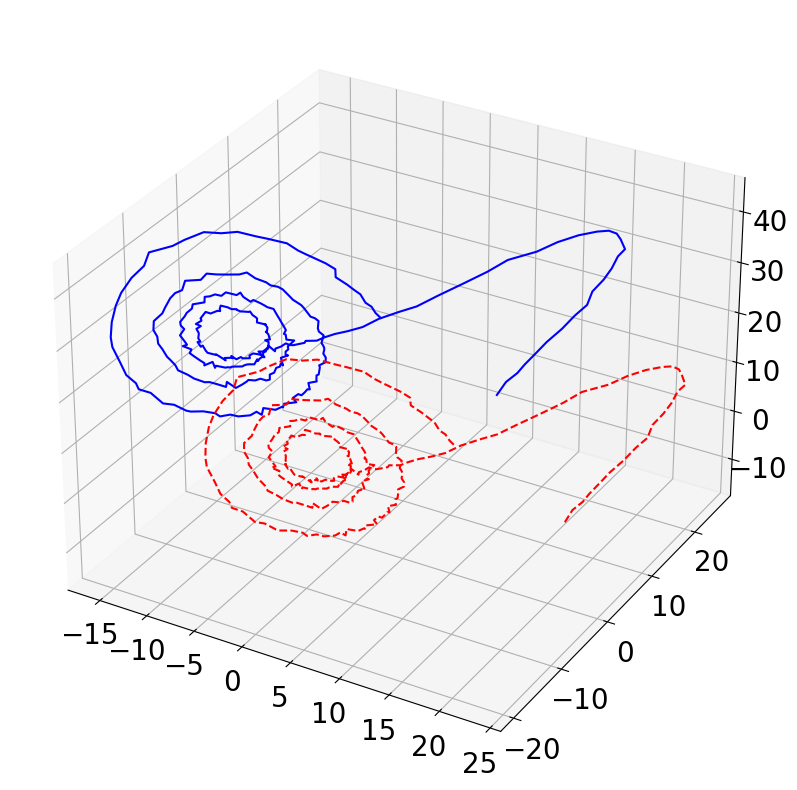

In [8]:
# Set random seed
seed = 1

# Process & measurement noise
sigma_process = 0
sigma_process_0 = 0
sigma_measure = 0.2

# System parameters
sigma = 10.0
beta = 8/3
rho = 28.0
A = 0.0
omega = 1.0
params = np.array([sigma,beta,rho,A,omega])
args.m = 3

# Initial conditions
t0 = 0 # Start time
tf = 3 # End time
x0 = torch.tensor([10.,10.,10.]).to(args.device) # Initial position
x0_2 = torch.tensor([10.,10.,10.]).to(args.device) + torch.randn(3).to(args.device)/10

Lorenz1 = Lorenz(params,args.device).to(args.device)

# Instantiate the system model and simulator
sim = DynamicSim(args.device)
sim.set_model(Lorenz1)

# Run the simulation
X, X_measure, Xp = sim.simulate_ODE(x0, tf, t0, args.dt, sigma_process, sigma_process_0, sigma_measure)
# X2, X_measure2, Xp2 = sim.simulate_ODE(x0_2, tf, t0, dt, sigma_process, sigma_process_0, sigma_measure)

tn1 = TemporalNorm()
X_measure2 = tn1.forward(X_measure)

# Plot
# X_plt = X.cpu().detach().numpy().squeeze().T
# X_plt2 = X2.cpu().detach().numpy().squeeze().T
X_plt = X_measure.cpu().detach().numpy().squeeze().T
X_plt2 = X_measure2.cpu().detach().numpy().squeeze().T

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(X_plt[0], X_plt[1], X_plt[2], 'b')
ax.plot3D(X_plt2[0], X_plt2[1], X_plt2[2], 'r--')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.show()

Van der Pol Oscillator

In [10]:
# Set random seed
seed = 0

# Process & measurement noise
sigma_process = 0
sigma_process_0 = 0
sigma_measure = 0.02

# System parameters
mu = 1.0
params = np.array([mu])

# Dimensions
n = 10
args.m = 2*n

# Initial state (positions randomly ±1, velocities zero)
x0 = torch.zeros(2 * n).to(args.device)
x0[:n] = torch.tensor([-1, 1])[torch.randint(0, 2, (n,))]

# Time span
t0 = 0.0
tf = 50.0
dt = 0.01

K = rand_coupling_matrix(n=n, omega=1, seed=seed, device=args.device)

# Instantiate the system model and simulator
osc = Van_der_Pol_osc(params, K)
sim = DynamicSim(args.device)
sim.set_model(osc)

# Run the simulation
X, X_measure, Xp = sim.simulate_ODE(x0, tf, t0, dt, sigma_process, sigma_process_0, sigma_measure)

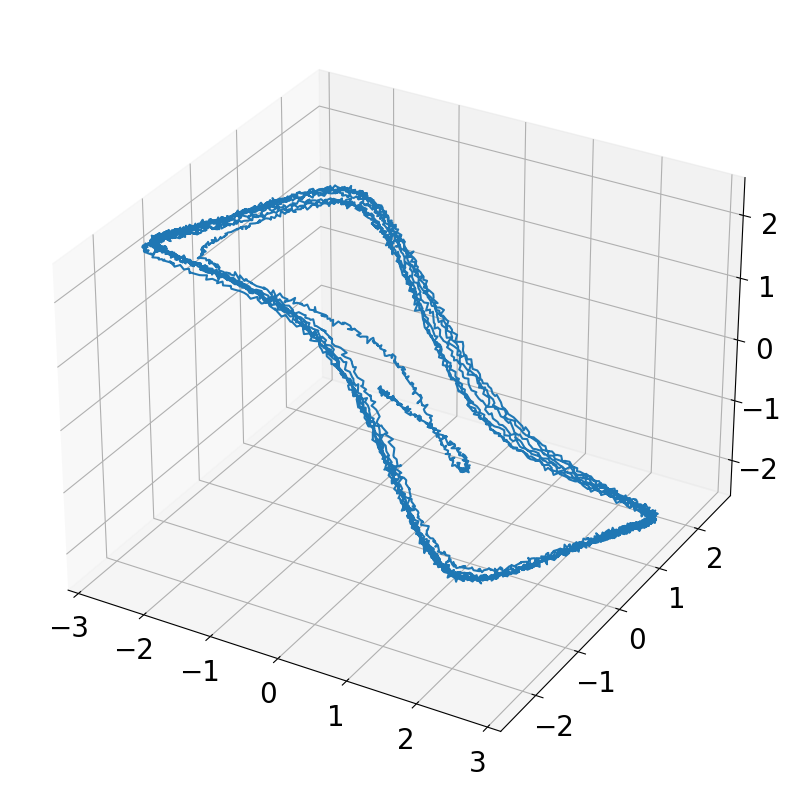

In [11]:
# X_plt = X.cpu().detach().numpy().squeeze().T
X_plt = X_measure.cpu().detach().numpy().squeeze().T
K_plt = K.detach().cpu().numpy()

# plt.imshow(K_plt)
# plt.show()

# import networkx as nx
# nx.draw_networkx(nx.from_numpy_array(K_plt),with_labels=False,node_size=20,node_color='k')
# plt.show()

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(X_plt[0], X_plt[1], X_plt[2])
# ax.plot3D(x_valid_plt[0], x_valid_plt[1], x_valid_plt[2])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.show()